This notebooks is hosted on [codeberg](https://codeberg.org/cknoll/kram/src/branch/main/python-stuff/mastodon-discourse-visualization). It demonstrates how to generate the following toot-relation-graph. Use ← → horizontal scrolling to see the full graph.


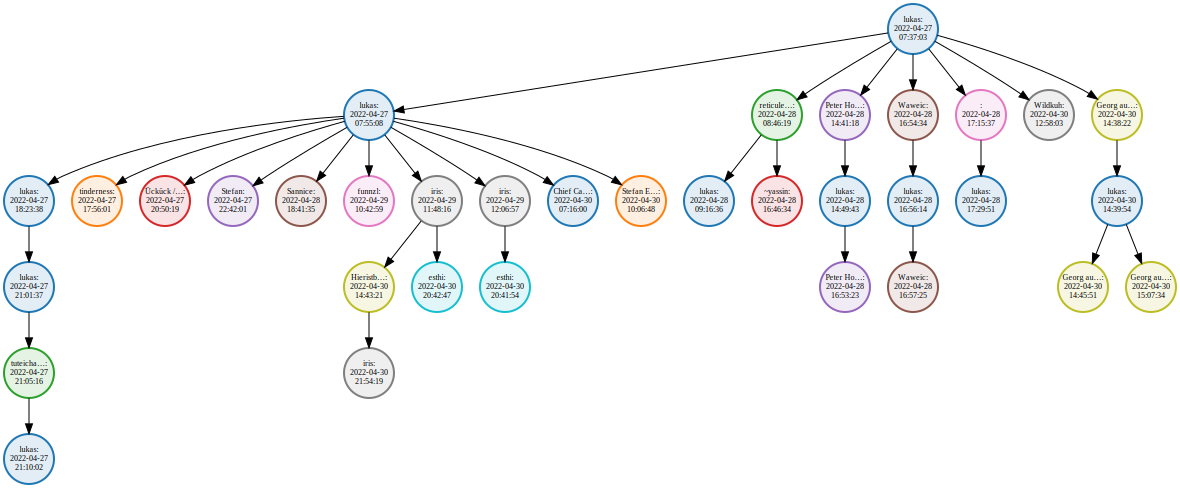

In [17]:
from IPython.display import SVG, display, HTML; svg_fname = "toot-analysis-108202886661881457.svg"; svgfile = open(svg_fname, "r"); svg_data = svgfile.read(); svgfile.close(); display(SVG(svg_data)) # note: this cell was created after the rest of the notebook. its purpose is to directly show the result (instead of hiding it below tons of boring code).

This notebook depends on some packages and files which are not part of this repo:

- https://mastodonpy.readthedocs.io/en/stable/index.html#
- https://networkx.org/documentation/stable/reference/drawing.html
- https://github.com/twosigma/nxv
- https://codeberg.org/cknoll/cachewrapper (optional)


Install these dependencies by 
```
pip install mastodonpy networkx nxv

```

In [2]:
import time
print(time.ctime())
# https://github.com/cknoll/ipydex (optional)
%load_ext ipydex.displaytools 

Mon May  2 19:27:33 2022


In [3]:
from mastodon import Mastodon  # https://mastodonpy.readthedocs.io/en/stable/index.html#
import networkx as nx  # https://networkx.org/documentation/stable/reference/drawing.html
import nxv  # https://github.com/twosigma/nxv
from matplotlib import pyplot as plt
try:
    import cachewrapper as cw # https://codeberg.org/cknoll/cachewrapper (optional)
except ImportError:
    cw = None
from IPython.display import SVG, display, HTML


masto_url = "https://social.tchncs.de"
cache_path = "cache.pcl"


# mc means "mastodon-client"
mc = Mastodon(
    access_token = 'pymastoclient_usercred.secret',
    api_base_url = masto_url,
)

# this is optional (to save api-calls)
if 0 and cw:
    mc = cw.CacheWrapper(mc)
    mc.load_cache(cache_path)

# id taken from local url (click on `···`→ expand this post (in the toot)  )
root_id = "108202886661881457"
res = mc.status_context(root_id) ##:i
#mc.save_cache(cache_path)

ancestors = res["ancestors"] ##:i
descendants = res["descendants"] ##:i

info(res) := "<class 'mastodon.Mastodon.AttribAccessDict'> with length: 2"

---

info(ancestors) := "<class 'list'> with length: 0"

---

info(descendants) := "<class 'list'> with length: 34"

---

In [4]:
res.keys()

dict_keys(['ancestors', 'descendants'])

In [5]:
# ancestors

In [6]:
# instantiate the default color_cycler from matlotlib
color_cycler = plt.rcParamsDefault['axes.prop_cycle']()
# next(color_cycler) -> {'color': '#2ca02c'} etc

In [7]:
author_color_map = {}

In [8]:
def get_author_color(data):
    aid = data["account"]["id"]
    color = author_color_map.get(aid)
    if color:
        return color
    else:
        # get new color from cycler, save it, return it
        color = next(color_cycler)["color"]
        author_color_map[aid] = color
        return color
    

In [9]:
class Node(object):
    def __init__(self, data: dict):
        self.id = str(data["id"])
        self.label = self.id
        self.data = data
        self.title= "foo"
        
        
        author = data["account"]["display_name"]
        N = 10
        if len(author) > N:
            author = f"{author[:N-2]}…"
        # label-trick: generate strings like r'{K12345}'
        # these can be substituted later -> two keys for linebreak
        self.repr_str = f"{author}:\n{{K{self.id}}}\n{{X{self.id}}}"
        
        self.style_dict = {
            "color": get_author_color(data),
            "fillcolor": get_author_color(data)+"20", # add low alpha-value for transparency
            "style": "filled",
            "shape": "circle",
            "fixedsize": True,
            "width": 0.7,
            "fontsize": 8,
            "penwidth": 2,

        }

    def __repr__(self):
        
        return self.repr_str

In [10]:
G = nx.DiGraph()

root_node = Node(data=mc.status(root_id))
id_map = {root_id: root_node}

G.add_node(root_node)
parent = root_node

for obj_data in descendants:
    node = Node(obj_data)
    id_map[node.id] = node
    
    parent = id_map[str(node.data["in_reply_to_id"])]
    G.add_node(node, color="red", shape="pentagon")
    G.add_edge(parent, node)
    
    


In [11]:
nn = list(G.nodes)[0]

In [12]:
import bleach

In [13]:
bleach.clean(nn.data["content"], tags=[], strip=True)

'Sicherlich interessant für viele unter #neuhier : Falls ihr Links zu Instagram, Twitter oder YouTube in euren Fediverse-Beiträgen verwendet, greift hierfür bitte auf die datenschutzfreundlichen Webfrontends, Bibliogram (für Instagram), Nitter (für Twitter) und Invidious (für YouTube) zurück.Weitere Informationen zu den datenschutzfreundlicheren Webfrontends könnt ihr in einem Beitrag von @kuketzblog nachlesen: https://www.kuketz-blog.de/datenschutzfreundliche-web-frontends-fuer-youtube-twitter-instagram-reddit-und-co/'

In [14]:
# <title>node0009</title>
old_title_str_template = "<title>node{:04d}</title>" 
new_title_str_template = "<title>{}</title>"


# generate replacement tuples
rpl_tuples = []
for i, node in enumerate(G.nodes):
    s1 = old_title_str_template.format(i)
    stripped_content = bleach.clean(node.data["content"], tags=[], strip=True)
    s2 = new_title_str_template.format(stripped_content)
    rpl_tuples.append((s1, s2))

In [15]:
# see https://nxv.readthedocs.io/en/latest/reference.html#styling
style = nxv.Style(
    graph={"rankdir": "TB"},
    node=lambda u, d: u.style_dict,
        # u is a node and d is its attribute dict (which is ignored here)
    edge=lambda u, v, d: {"style": "solid", "arrowType": "normal", "label": ""},
)



svg_data = nxv.render(G, style, format="svg")

entity_links = []

for node in G.nodes.keys():
    date = node.data["created_at"]
    str1 = f'<a href="{node.data["url"]}">{date.strftime("%Y-%m-%d")}</a>'
    str2 = f'<a href="{node.data["url"]}">{date.strftime("%H:%M:%S")}</a>'
    entity_links.append((f"K{node.id}", str1))
    entity_links.append((f"X{node.id}", str2))

# insert links to wiki data urls
svg_data = svg_data.decode("utf8").format(**dict(entity_links))

for s1, s2 in rpl_tuples:
    svg_data = svg_data.replace(s1, s2)

svg_data = svg_data.encode("utf8")

svg_fname = f"toot-analysis-{root_id}.svg"

with open(svg_fname, "wb") as svgfile:
    svgfile.write(svg_data)

#display(SVG(svg_data))

display(HTML(f"<a href='{svg_fname}'>{svg_fname}</a>"))


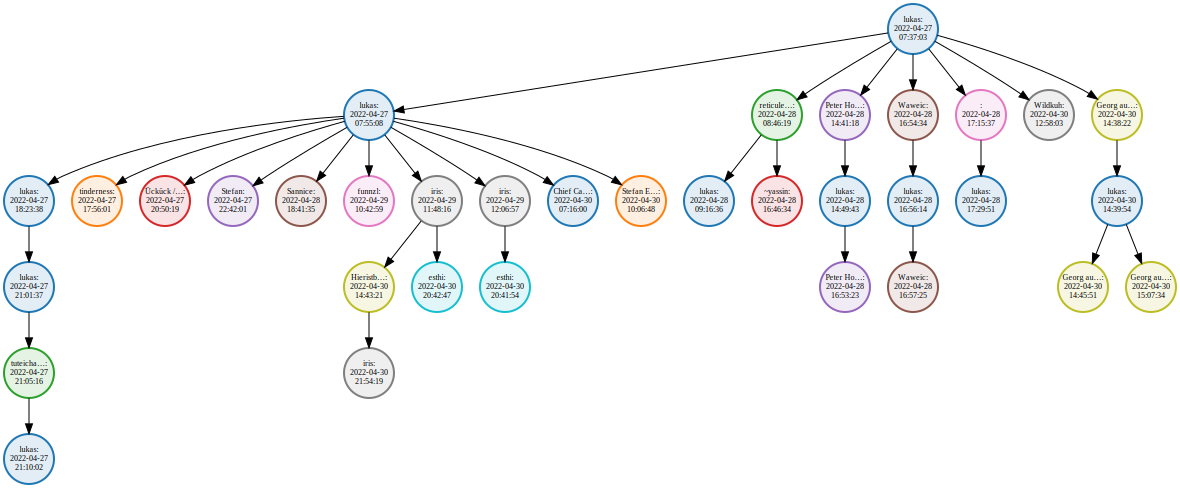

In [16]:
# display(HTML(f"<img src='{svg_fname}'>")) # this is prone to unexpected behavior due to caching
display(SVG(svg_data))
# click in the gray area below `In [..]` to disable/enable scrolling